# Recurrent Inference Machines (RIM) for Denoising MNIST (handwritten digits)
Follows implementation of RIM of paper "Recurrent Inference Machines for Solving Inverse Problems" (https://arxiv.org/pdf/1706.04008.pdf).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.utils.data as Data
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Load MNIST and create datasets & dataloaders

In [ ]:
# Use download=True if not already downloaded
transform = transforms.Compose([transforms.ToTensor()])

train_dat = dsets.MNIST("data/", train=True, download=False, transform=transform)
test_dat = dsets.MNIST("data/", train=False, download=False, transform=transform)

Our target is to de-noise $y_i = x_i + n_i$, where $n_i \sim \mathcal{N}(0,\sigma^2)$ and $\sigma^2 = 0.10$.

In [6]:
X_train, X_train_labels = train_dat.data[:-10000], train_dat.targets[:-10000]
X_val, X_val_labels = test_dat.data[-10000:], train_dat.targets[-10000:]
X_test, X_test_labels = test_dat.data, test_dat.targets

# Y_train = torch.tensor(np.array([gaussian_filter(X_train[i], 1.5) for i in range(X_train.shape[0])]))
# Y_val = torch.tensor(np.array([gaussian_filter(X_val[i], 1.5) for i in range(X_val.shape[0])]))
# Y_test = torch.tensor(np.array([gaussian_filter(X_test[i], 1.5) for i in range(X_test.shape[0])]))

Y_train = torch.tensor(random_noise(X_train, mode='gaussian', mean=0, var=0.1, clip=True))
Y_val = torch.tensor(random_noise(X_val, mode='gaussian', mean=0, var=0.1, clip=True))
Y_test = torch.tensor(random_noise(X_test, mode='gaussian', mean=0, var=0.1, clip=True))

Example of target image $x_i$ and noisy measurerument $y_i$.

Text(0.5, 1.0, '$y_i=x_i+n_i$')

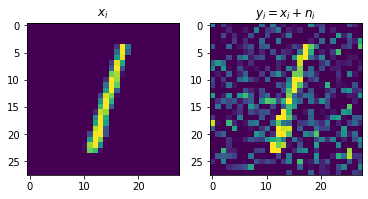

In [7]:
plt.subplot(1,2,1)
plt.imshow(X_test[2])
plt.title('$x_i$')
plt.subplot(1,2,2)
plt.imshow(Y_test[2])
plt.title('$y_i=x_i+n_i$')

Define batch size reate Dataloaders

In [8]:
batch_size = 128

train_dataset = Data.TensorDataset(X_train, Y_train)
val_dataset = Data.TensorDataset(X_val, Y_val)
test_dataset = Data.TensorDataset(X_test, Y_test)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True)

## Define a function that will give the gradient $\nabla_{y|x}$

In [9]:
def gradient(X, Y):
    
    return X - Y

## Define Conv2dRNNCell, RNN and RIM Modules: 

In [10]:
class Conv2dRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size, bias=True, nonlinearity="tanh"):
        super(Conv2dRNNCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        if type(kernel_size) == tuple and len(kernel_size) == 2:
            self.kernel_size = kernel_size
            self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        elif type(kernel_size) == int:
            self.kernel_size = (kernel_size, kernel_size)
            self.padding = (kernel_size // 2, kernel_size // 2)
        else:
            raise ValueError("Invalid kernel size.")

        self.bias = bias
        self.nonlinearity = nonlinearity

        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Conv2d(in_channels=input_size,
                             out_channels=hidden_size,
                             kernel_size=self.kernel_size,
                             padding=self.padding,
                             bias=bias)

        self.h2h = nn.Conv2d(in_channels=hidden_size,
                             out_channels=hidden_size,
                             kernel_size=self.kernel_size,
                             padding=self.padding,
                             bias=bias)
        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)


    def forward(self, input, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size, height_size, width_size)
        #       hx: of shape (batch_size, hidden_size, height_size, width_size)
        # Outputs:
        #       hy: of shape (batch_size, hidden_size, height_size, width_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size, input.size(2), input.size(3)))
        # print(input.shape)
        hy = (self.x2h(input) + self.h2h(hx))

        if self.nonlinearity == "tanh":
            hy = torch.tanh(hy)
        else:
            hy = torch.relu(hy)

        return hy

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_sizes, output_size, activation='relu'):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation = activation

        self.rnncell1 = Conv2dRNNCell(input_size=input_size, hidden_size=hidden_size, kernel_size=kernel_sizes[0], nonlinearity=activation)
        self.rnncell2 = Conv2dRNNCell(input_size=hidden_size, hidden_size=hidden_size, kernel_size=kernel_sizes[1], nonlinearity=activation)
        self.conv = nn.Conv2d(in_channels=hidden_size*2, out_channels=output_size, kernel_size=kernel_sizes[2], padding=kernel_sizes[2]//2)

        # nn.init.xavier_normal_(self.fc.weight, 0.1)

    def forward(self, xt, st=None):

        if st is None:
            st = [Variable(xt.new_zeros(xt.size(0), self.hidden_size, xt.size(2), xt.size(3))),
                  Variable(xt.new_zeros(xt.size(0), self.hidden_size, xt.size(2), xt.size(3)))]

        st_1 = self.rnncell1(xt, st[0])
        st_2 = self.rnncell2(st_1, st[1])
        dxt = self.conv(torch.cat((st_1, st[1]), 1))

        st = [st_1, st_2]

        return dxt, st


class RIM(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_sizes, output_size, sequence_size,
                 gradient_fun, activation='relu'):
        super(RIM, self).__init__()

        self.input_size = input_size  
        self.hidden_size = hidden_size
        self.kernel_sizes = kernel_sizes
        self.output_size = output_size
        self.sequence_size = sequence_size
        self.gradient_fun = gradient_fun

        # input is ([x, grad_{y|x}])
        self.rnn = RNN(input_size=input_size*2, hidden_size=hidden_size, kernel_sizes=kernel_sizes, output_size=output_size, activation=activation)

    def forward(self, x, y):

        # x is only used for shape matching
        x0 = torch.zeros(x.shape)
        xt = x0.clone().to(device)

        grad_xt = self.gradient_fun(xt, y).clone().to(device)

        input_t = Variable(torch.cat((xt, grad_xt), 1)).to(device)
        st = None
        X = torch.zeros((self.sequence_size+1, x0.size(0), self.input_size, x0.size(2), x0.size(3)))
        X[0] = y.clone()
        for t in range(self.sequence_size):

            dxt, st = self.rnn(input_t, st)

            xt = xt + dxt

            grad_xt = self.gradient_fun(xt, y).clone()
            input_t = Variable(torch.cat((xt, grad_xt), 1))

            X[t+1] = xt.clone()
            
        return X.to(device)


## RIM - training

In [125]:
sequence_len = 10
rim = RIM(1, 32, (5,3,3), 1, sequence_len, gradient)
rim.to(device)

criterion = nn.MSELoss()
learning_rate = 0.0002
optimizer = torch.optim.Adam(rim.parameters(), lr=learning_rate)

epochs = 200
losses = []
val_losses = []

iter = 0
################################################################################
#---------------------------------TRAINING-------------------------------------#
################################################################################
for epoch in range(epochs):

    train_loss = 0.0
    for i, (X, y) in enumerate(train_loader):

        X = Variable(X).to(device).unsqueeze(1).float()
        y = Variable(y).to(device).unsqueeze(1).float()
        
        optimizer.zero_grad()

        outputs = rim(X, y)
        loss = 0.0

        # Target tensor is X
        for t in range(sequence_len):
            loss += criterion(outputs[t], X) / sequence_len

        loss.to(device)

        train_loss += loss.item()
        
        iter += 1

        # get gradients w.r.t to parameters
        loss.backward()
        
        # update parameters
        optimizer.step()

    ############################################################################
    #------------------------------VALIDATION----------------------------------#
    ############################################################################

    rim.eval()
    valid_loss = 0.0

    for i, (X, y) in enumerate(test_loader):

        X = Variable(X).to(device).unsqueeze(1).float()
        y = Variable(y).to(device).unsqueeze(1).float()

        outputs = rim(X, y)
        loss = 0.0

        for t in range(sequence_len):

            loss += criterion(outputs[t], X) / sequence_len
        
        valid_loss += loss.to(device).item()  
    

    val_losses.append(valid_loss / len(test_loader.dataset))

    rim.train()
    losses.append(train_loss / len(train_loader.dataset))

    print("Epoch: {}. Train Loss: {}. Validation. Loss: {}.".format(epoch, losses[epoch], val_losses[epoch]))  

# torch.save(rim.state_dict(), './rim.pt')

Epoch: 0. Train Loss: 27.3684102734375. Validation. Loss: 20.74411357421875.
Epoch: 1. Train Loss: 18.56487140625. Validation. Loss: 17.560221435546875.
Epoch: 2. Train Loss: 16.59520004638672. Validation. Loss: 16.34070157470703.
Epoch: 3. Train Loss: 15.627277607421876. Validation. Loss: 15.535885766601563.
Epoch: 4. Train Loss: 14.888795913085938. Validation. Loss: 14.802363012695313.
Epoch: 5. Train Loss: 14.296494638671875. Validation. Loss: 14.28794384765625.
Epoch: 6. Train Loss: 13.8252791796875. Validation. Loss: 13.834017724609375.
Epoch: 7. Train Loss: 13.425241091308594. Validation. Loss: 13.473052197265625.
Epoch: 8. Train Loss: 13.057071037597657. Validation. Loss: 13.10791708984375.
Epoch: 9. Train Loss: 12.722387185058594. Validation. Loss: 12.767900952148437.
Epoch: 10. Train Loss: 12.424164438476563. Validation. Loss: 12.489042272949218.
Epoch: 11. Train Loss: 12.161047888183594. Validation. Loss: 12.232652905273438.
Epoch: 12. Train Loss: 11.936811137695312. Validati

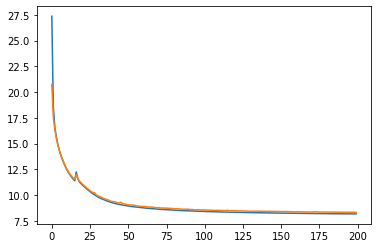

In [127]:
plt.plot(losses)
plt.plot(val_losses)

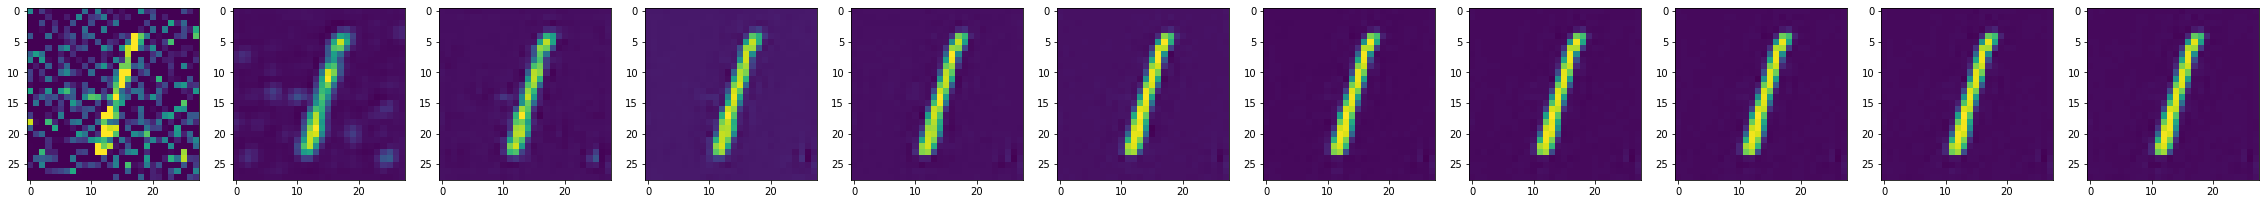

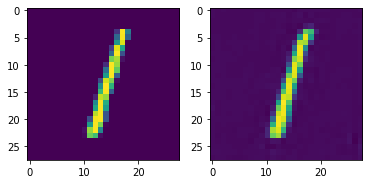

In [13]:
rim.to(device)
rim.eval()

xx = rim(X_test[2].reshape(1,1,28,28).float().to(device), Y_test[2].reshape(1,1,28,28).float().to(device)).reshape(11,28,28)
plt.figure(figsize=(40, 5))
for i in range(1, xx.size(0) + 1):

    plt.subplot(1, xx.size(0), i)
    plt.imshow(xx[i-1].detach().cpu().numpy())
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X_test[2])
plt.subplot(1,2,2)
plt.imshow(xx[-1].detach().cpu().numpy())
